In [35]:
import os
import sys

sys.path.append("../model")
sys.path.append("..")
import geopandas as gpd
import math
import json
import numpy as np
import rioxarray
from rasterio import RasterioIOError
import xarray as xr
import pickle as pkl
from datetime import date
from collections import defaultdict
from shapely.geometry import Point
import torch
import yaml
from box import Box
import matplotlib.pyplot as plt
from sklearn import decomposition
from torchvision.transforms import v2
from src.model import ClayMAEModule


updated_tiles_gdf = gpd.read_file("../data/tiles_with_dates.geojson")
county_boundary = gpd.read_file("../data/county_boundary.shp")
tiles_data_dir = "../data/tiles_gdb"

bands = ["B02", "B03", "B04", "B08"]
bands_map = {"B02": "blue", "B03": "green", "B04": "red", "B08": "nir"}
gsd = 10
epsg = 32617

# Date Range
start = "2016-01-01"
end = "2024-08-31"

def select_dates_best_spread(dates_list, num_per_year=4):
    # Sort the dates list
    dates_list.sort()
    
    # Determine target months based on the desired number per year
    target_months = {
        4: [3, 6, 9, 12],  # Default quarters: March, June, September, December
        3: [4, 8, 12],     # For 3 dates per year: April, August, December
        2: [6, 12],        # For 2 dates per year: June, December
        1: [6]             # For 1 date per year: June
    }.get(num_per_year, [6])  # Default to June if an unexpected `num_per_year` is given
    

    # Group dates by year
    dates_by_year = defaultdict(list)
    for d in dates_list:
        dates_by_year[d.year].append(d)
    
    selected_dates = []
    
    # Iterate over each year and select the best spread dates
    for year in sorted(dates_by_year.keys()):
        available_dates = dates_by_year[year]
        
        for month in target_months:
            # Set the target date as the 1st of the target month
            target_date_in_year = date(year, month, 1)
            
            # Find the closest date in the available dates to the target date
            closest_date = min(available_dates, key=lambda d: abs(d - target_date_in_year))
            
            # Check if the selected date is not already in the list
            if closest_date not in selected_dates:
                selected_dates.append(closest_date)
    
    # Post-process to ensure cross-year spread is handled
    selected_dates.sort()
    return selected_dates

with open("../data/available_dates.pkl", "rb") as f:
    available_dates = pkl.load(f)
selected_dates = select_dates_best_spread([d for d in available_dates if d !=  date(2017, 5, 16) 
                                           and d != date(2024, 8, 27)], 3) # 5/16 is basically unavailable, and 8/25 is already there

# Model
# `git clone https://github.com/Clay-foundation/model.git`
# Download clay-v1-base.ckpt from https://huggingface.co/made-with-clay/Clay/tree/main

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
ckpt = "../clay-ckpt/clay-v1-base.ckpt"
metadata_path = "../model/configs/metadata.yaml" 
torch.set_default_device(device)

model = ClayMAEModule.load_from_checkpoint(
    ckpt, metadata_path=metadata_path, shuffle=False, mask_ratio=0
)
model.eval()
model = model.to(device)

def get_by_idx(tile_idx, gdf, bands):
    tile_data_files = json.loads(gdf.at[tile_idx, 'date_files_mapping'])
    datasets = []
    for query_date in list(tile_data_files.keys()):
        data_file = tile_data_files[query_date][0]
        ds = rioxarray.open_rasterio(data_file)
        date_str = ds.time
        date = np.datetime64(date_str, 'ns')
        ds = ds.assign_coords(band=bands)
        ds = ds.expand_dims({'time': [date]})
        datasets.append(ds)
    stacked_ds = xr.concat(datasets, dim='time')
    return stacked_ds

def get_stack_centroid_lat_lon(stack):
    # Extract the x and y coordinates
    x_coords = stack['x'].values
    y_coords = stack['y'].values
    # Compute the centroid in the dataset's CRS
    x_min = x_coords.min()
    x_max = x_coords.max()
    y_min = y_coords.min()
    y_max = y_coords.max()
    x_centroid = (x_min + x_max) / 2
    y_centroid = (y_min + y_max) / 2
    # Create a GeoDataFrame with the centroid point
    centroid_point = Point(x_centroid, y_centroid)
    gdf = gpd.GeoDataFrame(geometry=[centroid_point], crs=stack.rio.crs)
    # Reproject to WGS84 (EPSG:4326)
    gdf_wgs84 = gdf.to_crs('EPSG:4326')
    # Extract latitude and longitude
    lon = gdf_wgs84.geometry.x.values[0]
    lat = gdf_wgs84.geometry.y.values[0]
    return lat, lon

def stack_transform(stack, bands_map, platform="sentinel-2-l2a"):
    metadata = Box(yaml.safe_load(open(metadata_path)))
    # Extract mean, std, and wavelengths from metadata
    mean = []
    std = []
    waves = []
    # Use the band names to get the correct values in the correct order.
    for band in stack.band.values:
        mean.append(metadata[platform].bands.mean[bands_map[str(band)]])
        std.append(metadata[platform].bands.std[bands_map[str(band)]])
        waves.append(metadata[platform].bands.wavelength[bands_map[str(band)]])

    # Prepare the normalization transform function using the mean and std values.
    transform = v2.Compose(
        [
            v2.Normalize(mean=mean, std=std),
        ]
    )
    return mean, std, waves, transform 

# Prep datetimes embedding using a normalization function from the model code.
def normalize_timestamp(date):
    week = date.isocalendar().week * 2 * np.pi / 52
    hour = date.hour * 2 * np.pi / 24

    return (math.sin(week), math.cos(week)), (math.sin(hour), math.cos(hour))

# Prep lat/lon embedding using the
def normalize_latlon(lat, lon):
    lat = lat * np.pi / 180
    lon = lon * np.pi / 180

    return (math.sin(lat), math.cos(lat)), (math.sin(lon), math.cos(lon))

def get_datacube(stack, device, bands_map, platform="sentinel-2-l2a"):

    _mean, _std, waves, transform = stack_transform(stack, bands_map, platform)

    datetimes = stack.time.values.astype("datetime64[s]").tolist()
    times = [normalize_timestamp(dat) for dat in datetimes]
    week_norm = [dat[0] for dat in times]
    hour_norm = [dat[1] for dat in times]

    lat, lon = get_stack_centroid_lat_lon(stack)

    latlons = [normalize_latlon(lat, lon)] * len(times)
    lat_norm = [dat[0] for dat in latlons]
    lon_norm = [dat[1] for dat in latlons]

    # Normalize pixels
    pixels = torch.from_numpy(stack.data.astype(np.float32))
    pixels = transform(pixels)

    # Prepare additional information
    datacube = {
        "platform": platform,
        "time": torch.tensor(
            np.hstack((week_norm, hour_norm)),
            dtype=torch.float32,
            device=device,
        ),
        "latlon": torch.tensor(
            np.hstack((lat_norm, lon_norm)), 
            dtype=torch.float32, device=device
        ),
        "pixels": pixels.to(device),
        "gsd": torch.tensor(0.6, device=device),
        "waves": torch.tensor(waves, device=device),
    }
    return datetimes, datacube

def get_embeddings(datacube):
    with torch.no_grad():
        unmsk_patch, unmsk_idx, msk_idx, msk_matrix = model.model.encoder(datacube)

    # The first embedding is the class token, which is the overall single embedding. 
    embeddings = unmsk_patch[:, 0, :].cpu().numpy()
    return embeddings

c:\Users\btripp\urban-clay\env\Lib\site-packages\torch\nn\modules\transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


In [43]:
if not os.path.exists("../data/gdf_with_embeddings.pkl"):
    updated_tiles_gdf = gpd.read_file("../data/tiles_with_dates.geojson")
    updated_tiles_gdf["embeddings"] = None
    updated_tiles_gdf["datetime"] = None
else:
    with open("../data/gdf_with_embeddings.pkl", "rb") as f:
        updated_tiles_gdf = pkl.load(f)

for idx in range(len(updated_tiles_gdf)):
    # If there is already a value at this idx, skip
    if updated_tiles_gdf.at[idx, "embeddings"] is None and updated_tiles_gdf.at[idx, "datetime"] is None:
        try:
            stack = get_by_idx(idx, updated_tiles_gdf, bands)
            datetimes, datacube = get_datacube(stack, device, bands_map)
            embeddings = get_embeddings(datacube)
            updated_tiles_gdf.at[idx, "datetime"] = datetimes
            updated_tiles_gdf.at[idx, "embeddings"] = embeddings
            print(f"Stored embeddings for index {idx} in the GDF")
        except RasterioIOError as e:
            print(f"Error at index {idx}:")
            print(e)

with open("../data/gdf_with_embeddings.pkl", "wb") as f:
    pkl.dump(updated_tiles_gdf, f)


Patches shape: torch.Size([25, 49, 768])
Grid size: 7
Stored embeddings for index 0 in the GDF
Patches shape: torch.Size([25, 49, 768])
Grid size: 7
Stored embeddings for index 1 in the GDF
Patches shape: torch.Size([25, 49, 768])
Grid size: 7


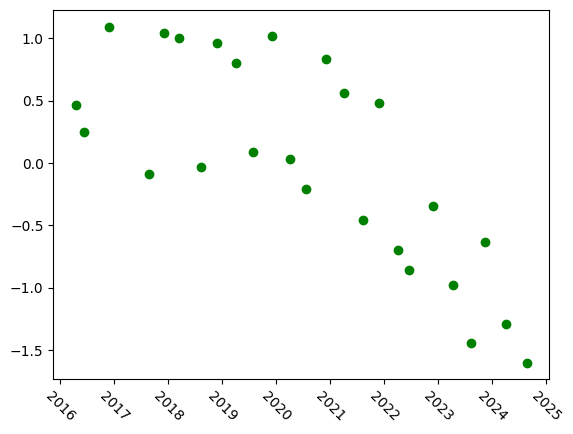

In [33]:
# Example: Run PCA
# stack.sel(band=["B02", "B03", "B04"]).plot.imshow(
#     row="time", rgb="band", vmin=0, vmax=2000, col_wrap=5
# )
# plt.show()

pca = decomposition.PCA(n_components=1)
pca_result = pca.fit_transform(embeddings)

plt.figure()
plt.xticks(rotation=-45)
plt.scatter(stack.time, pca_result, color="green")
plt.show()

### A Quick Review of the Problem

The dataset consists of 5,500 embeddings, each representing a 25x768 matrix for tiles within a 600x600 meter grid in Johnston County, NC. The embeddings are derived 
from Sentinel-2-L2A satellite imagery spanning April 2016 to August 2024, approximately every 3-4 months, using the CLAY Foundation Model. Each embedding captures 
spectral information across 25 dates, accommodating a buffer to compensate for slight misalignments in Sentinel-2's imaging dates. These tiles correspond to 25 specific 
dates listed in `selected_dates` in chronological order, with each date aligning with the rows in the "embeddings" column of the GeoDataFrame, stored in matrices. 

The objective is to train a model to estimate urban imperviousness within the region over time using these embeddings, with reference data from the NLCD, which updates 
every five years. To generate training labels, the NLCD data will be spatially aggregated to match the tile structure and resolution of the Sentinel-2 embeddings. The 
model will be trained using a random sample of the embeddings and aggregated NLCD values from 2016-2017 to capture seasonal variations, with a portion of this data 
reserved for testing. Once trained, the model will be applied to estimate urban imperviousness across the full timeframe of the embeddings.

### Data Setup

1. **Aggregate Labels:** Aggregate the NLCD data by each 600x600m tile to generate a single imperviousness value per tile as the label. This could involve computing
   the mean imperviousness or a threshold-based metric (e.g., percentage above a certain imperviousness level) within each tile, which will create labels matching 
   the spatial granularity of the embeddings.

2. **Embedding Structure:** To facilitate training, organize the embeddings from the "embeddings" column into a structured dataset where each row corresponds to a 
   tile and contains:
   - A flattened version of the 25x768 embeddings (i.e., a 1D vector of 19,200 features) or a sequence structure if the model architecture allows.
   - A label column with the corresponding imperviousness value per tile from the NLCD.

3. **Temporal Stratification:** Split the data based on dates for training and testing. Use embeddings from 2016 and early 2017 for training to cover seasonal 
   variations, then reserve a portion from this period for testing. Later, extend predictions across the full date range.

4. **Data Scaling and Preparation:** Normalize or standardize the embeddings if required by the model. Consider dimensionality reduction (e.g., PCA)
   on the embeddings to manage the feature count if computational limits arise.

5. **Model Selection:** Use a model suited for time-series or spatial data (e.g., LSTM, Transformer, or CNN-based architectures), given the temporal and spatial 
   dimensions of the embeddings.